# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.


## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/CherryLeaves_Sample1')
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'/workspace/CherryLeaves_Sample1'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

          Set           Label  Frequency
0       train         healthy       1472
1       train  powdery_mildew       1472
2  validation         healthy        210
3  validation  powdery_mildew        210
4        test         healthy        422
5        test  powdery_mildew        422


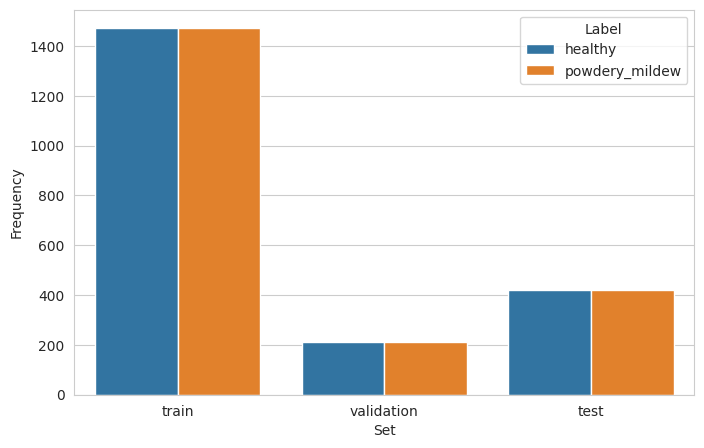

In [45]:
all_data = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        
        all_data.append({
            'Set': folder,
            'Label': label,
            'Frequency': num_images
        })

# Create the DataFrame in one go
df_freq = pd.DataFrame(all_data)

print(df_freq)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show() 

In [10]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show() 
 


AttributeError: 'DataFrame' object has no attribute 'append'

---

# Image data augmentation

---

### ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-24 08:28:02.121116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 08:28:02.165707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices
print("Class indices:", train_set.class_indices)

Found 2944 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}


In [14]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


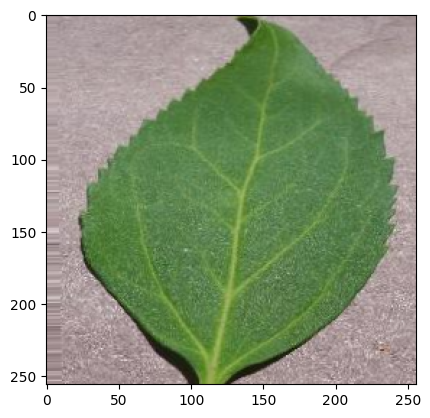

(20, 256, 256, 3)


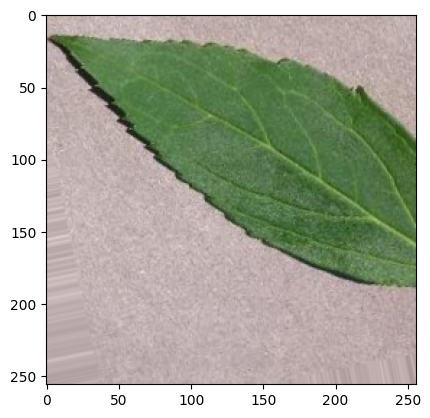

(20, 256, 256, 3)


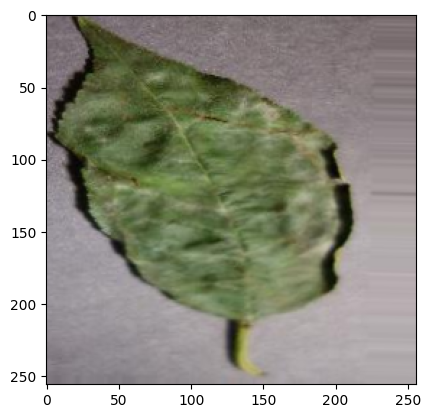

In [17]:
for _ in range(3):
    #  img, label = train_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()
 


## Plot augmented validation and test images

(20, 256, 256, 3)


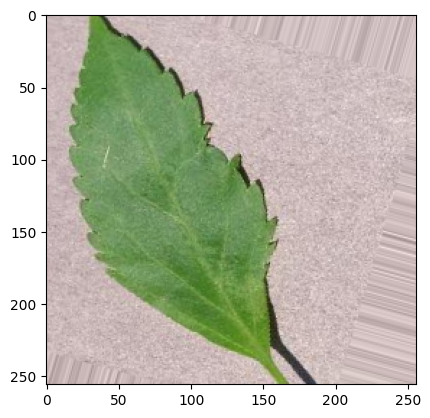

(20, 256, 256, 3)


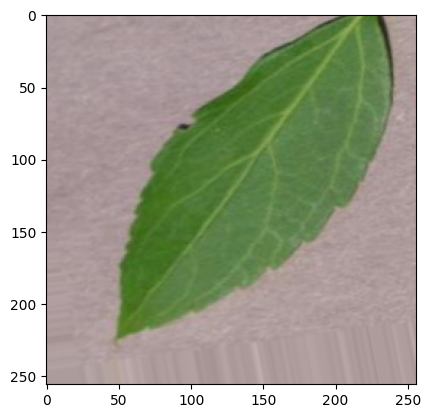

(20, 256, 256, 3)


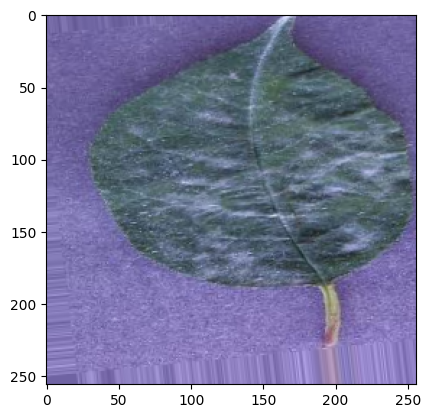

In [18]:
for _ in range(3):
    # img, label = validation_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 256, 256, 3)


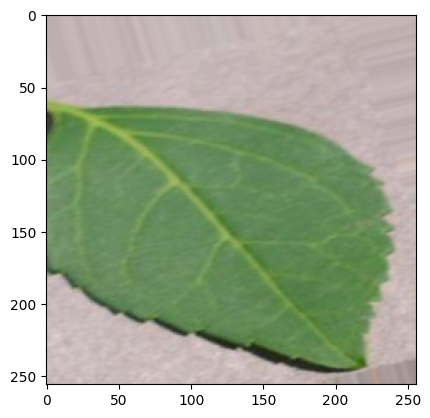

(20, 256, 256, 3)


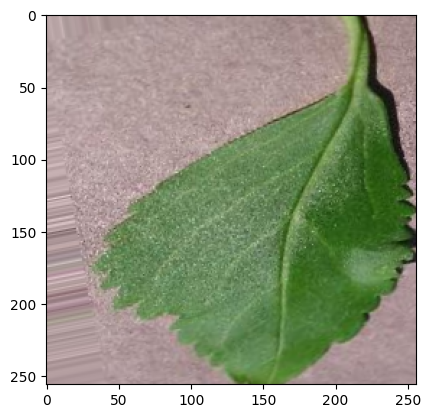

(20, 256, 256, 3)


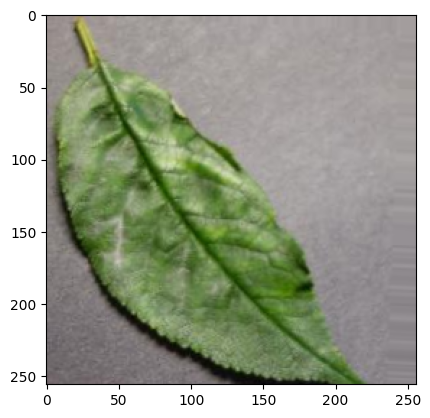

In [19]:
for _ in range(3):
    # img, label = test_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [24]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [25]:
create_tf_model().summary()

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [27]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 137s 914ms/step - accuracy: 0.7032 - loss: 0.6003 - val_accuracy: 0.9833 - val_loss: 0.0833
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:56 795ms/step - accuracy: 0.9500 - loss: 0.0822

2024-09-24 08:37:16.430787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9500 - loss: 0.0822 - val_accuracy: 0.9833 - val_loss: 0.0904
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 919ms/step - accuracy: 0.9737 - loss: 0.1010 - val_accuracy: 0.9881 - val_loss: 0.0433
Epoch 4/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:56 796ms/step - accuracy: 0.9500 - loss: 0.0564

2024-09-24 08:39:38.231966: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9500 - loss: 0.0564 - val_accuracy: 0.9952 - val_loss: 0.0257
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 134s 899ms/step - accuracy: 0.9826 - loss: 0.0609 - val_accuracy: 0.9976 - val_loss: 0.0253
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9500 - loss: 0.1101 - val_accuracy: 0.9976 - val_loss: 0.0255
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 915ms/step - accuracy: 0.9912 - loss: 0.0444 - val_accuracy: 0.9881 - val_loss: 0.0409
Epoch 8/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:44 713ms/step - accuracy: 1.0000 - loss: 0.0092

2024-09-24 08:44:18.840261: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9881 - val_loss: 0.0421


## Save model

In [47]:
model.save('outputs/v1/cherry_leaves_model.h5')
model.save('outputs/v1/cherry_leaves_model.keras')


---

# Model Performace

---

## Model learning curve

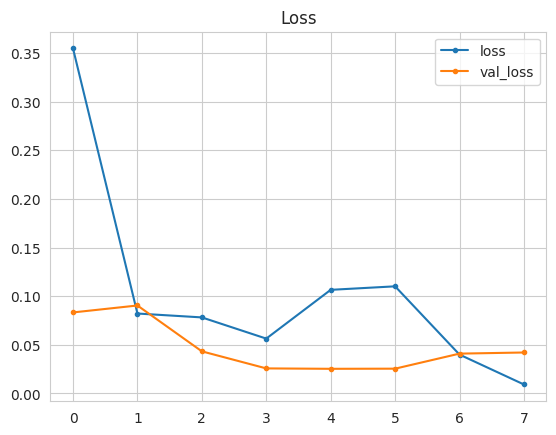

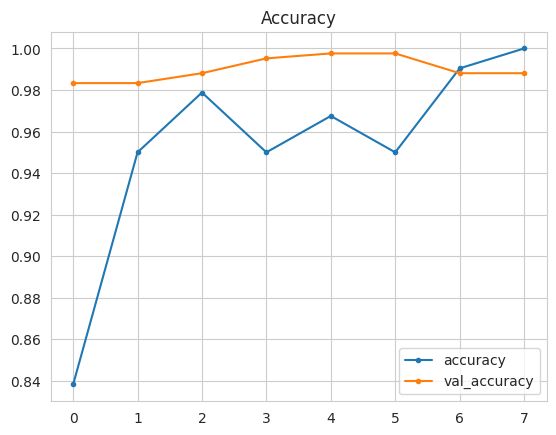

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [48]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')
model = load_model('outputs/v1/cherry_leaves_model.keras')

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluate model on test set

In [32]:
evaluation = model.evaluate(test_set)


 1/43 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step - accuracy: 1.0000 - loss: 0.0025

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9958 - loss: 0.0169


Create a confusion Matrix

In [1]:
validation_set.reset()


x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels


cm = confusion_matrix(y_true,y_pred)
sns_colours = sns.diverging_palette(20, 145, as_cmap=True)


classes=list(test_set.class_indices.keys())
length = len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=sns_colours)       
plt.xticks(np.arange(length) + .5, classes, rotation=0, fontsize=8)
plt.yticks(np.arange(length) + .3, classes, rotation=90, fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

NameError: name 'validation_set' is not defined

### Save evaluation pickle

In [33]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


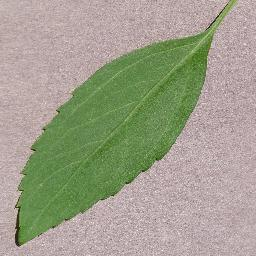

In [37]:
from tensorflow.keras.preprocessing import image

pointer = 146
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [38]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [39]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9999905421400399
healthy


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [40]:
!cat .gitignore

inputs/cherry-leaves/cherry-leaves/test
inputs/cherry-leaves/cherry-leaves/train
kaggle.json
*.ipynb
__pycache__/

* Git status

In [41]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .slugignore
	modified:   app_pages/page_leaves_visualizer.py
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842_flipTB.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600_flipTB.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/0580bdc7-e60e-4ba9-87dc-1202e57b94aa___JR_HL 4159.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/069996a8-8cdb-4837-a5fe-c5a957b5677a___JR_HL 3938.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/0982e1cc-78e8-4bb0-8969-c534e5b0b14b___JR_HL 4097_180deg.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/0e2e

* Git add

In [42]:
!git add .

* Git commit

In [43]:
!git commit -am "New Model 240924_1055"

[main 2b9c4f4] New Model 240924_1055
 784 files changed, 7 insertions(+), 6 deletions(-)
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9765_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842.JPG
 delete mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR

* Git Push

In [44]:
!git push

Enumerating objects: 427, done.
Counting objects: 100% (427/427), done.
Delta compression using up to 32 threads
Compressing objects: 100% (403/403), done.
Writing objects: 100% (407/407), 135.14 MiB | 12.73 MiB/s, done.
Total 407 (delta 6), reused 382 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/cherry_leaves_model.keras is 85.06 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: File outputs/v1/cherry_leaves_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/nianswe/CherryLeaves_Sample1.git
   a160d76..2b9c4f4  main -> main


---